## World Model Example:  MDN-RNN Demo

### University of Virginia
### Reinforcement Learning
#### Last updated: July 17, 2025

---

### Background

An MDN-RNN (Mixture Density Network + Recurrent Neural Network) is often used in world models as it powerfully combines:

- An RNN which incorporates sequence data

- An MDN which predicts the parameters of a mixture of Gaussians (mean, variance, weight) at each time step. This provides flexibility when the data may have different modes (e.g., bull and bear market in financial markets, for example).

---


### Instructions

Review the code below and try running with different settings to build an understanding.

The demo shows functionality for:
- Training a mn **MDN-RNN** model in PyTorch on mock data
- Sampling from the mixture distribution
- Sampling rollout trajectories and comparing to the target

Note: Starter code created by ChatGPT but it failed! and was revised.

#### Code

In [56]:
pip install torch

**Import Modules**

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F

**Define the Model**

For the RNN, we use an LSTM model

The MDN consists of a mixture of Gaussians (normals). Each Gaussian component will have an associated mean (mu), standard deviation (sigma), and weight (pi) for the mixture.

In [58]:
class MDNRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_gaussians, output_dim):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.n_gaussians = n_gaussians
        self.output_dim = output_dim

        # MDN output: pi, mu, sigma for each mixture component
        self.fc_pi = nn.Linear(hidden_dim, n_gaussians * output_dim)
        self.fc_mu = nn.Linear(hidden_dim, n_gaussians * output_dim)
        self.fc_sigma = nn.Linear(hidden_dim, n_gaussians * output_dim)

    def forward(self, x, hidden=None):
        # x: (batch, seq_len, input_dim)
        out, hidden = self.rnn(x, hidden)  # out: (batch, seq_len, hidden_dim)
        # predict MDN parameters
        pi = self.fc_pi(out)
        mu = self.fc_mu(out)
        sigma = self.fc_sigma(out)

        # reshape to (batch, seq_len, n_gaussians, output_dim)
        pi = pi.view(x.size(0), x.size(1), self.n_gaussians)
        mu = mu.view(x.size(0), x.size(1), self.n_gaussians, self.output_dim)
        sigma = sigma.view_as(mu)

        # apply activations
        pi = F.softmax(pi, dim=2)
        sigma = torch.exp(sigma)

        return pi, mu, sigma, hidden


**Loss Function**

In [59]:
def mdn_loss(pi, mu, sigma, target):
    # target: (batch, seq_len, output_dim)
    m = torch.distributions.Normal(mu, sigma)
    # compute log prob for each mixture
    log_prob = m.log_prob(target.unsqueeze(2))  # add mixture dim
    # sum over output_dim
    log_prob = log_prob.sum(-1)
    # we take the log and invert later
    log_pi = torch.log(pi) # shape: (batch, seq_len, n_gaussians)

    # multiply by mixture weights (pi)
    weighted = torch.logsumexp(log_pi + log_prob, dim=2)
    # negative mean log likelihood
    return -weighted.mean()


**Generate Data**

In [60]:
# Hyperparameters
input_dim = 1 # for simplicity
hidden_dim = 32
n_gaussians = 5
output_dim = 1
seq_len = 10
batch_size = 32

# Create random walk data as toy example
x = torch.randn(batch_size, seq_len, input_dim)
target = x.cumsum(dim=1) + 0.1 * torch.randn(batch_size, seq_len, output_dim)

**Train the Model**

In [61]:
model = MDNRNN(input_dim, hidden_dim, n_gaussians, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

losses = []

for epoch in range(200):
    optimizer.zero_grad()
    pi, mu, sigma, _ = model(x)
    loss = mdn_loss(pi, mu, sigma, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())  # store losses for plotting
    if epoch % 20 == 0:
        print(f"Epoch {epoch} - Loss: {loss.item():.4f}")


Epoch 0 - Loss: 3.5520
Epoch 20 - Loss: 2.0361
Epoch 40 - Loss: 1.0351
Epoch 60 - Loss: 0.4100
Epoch 80 - Loss: -0.1762
Epoch 100 - Loss: -0.4450
Epoch 120 - Loss: -0.3950
Epoch 140 - Loss: -0.1705
Epoch 160 - Loss: -0.6086
Epoch 180 - Loss: -0.7103


**Plot Training Loss**

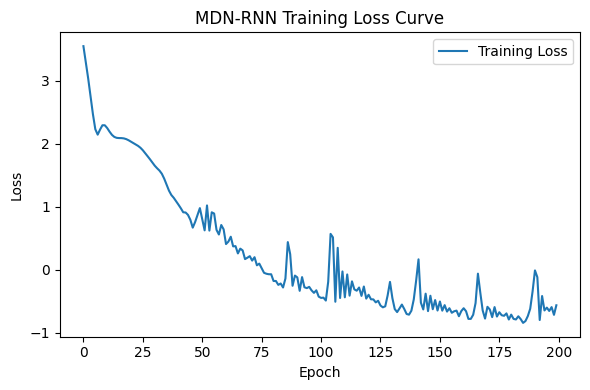

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("MDN-RNN Training Loss Curve")
plt.legend()
plt.tight_layout()
plt.show()

**Sample from MDN Model**

In [63]:
import torch

def sample_from_mdn(pi, mu, sigma):
    """
    Sample from the mixture density output.

    pi: (batch, seq_len, n_gaussians)
    mu: (batch, seq_len, n_gaussians, output_dim)
    sigma: (batch, seq_len, n_gaussians, output_dim)

    Returns:
    sample: (batch, seq_len, output_dim)
    """
    # Choose a Gaussian index from the categorical distribution
    categorical = torch.distributions.Categorical(pi)
    # sample shape: (batch, seq_len)
    indices = categorical.sample()

    # Gather mu and sigma for chosen indices
    batch_size, seq_len, n_gaussians, output_dim = mu.shape

    # reshape indices to (batch, seq_len, 1, 1) to broadcast
    idx = indices.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 1, output_dim)

    # gather mu and sigma at the chosen indices
    chosen_mu = torch.gather(mu, 2, idx).squeeze(2)       # shape: (batch, seq_len, output_dim)
    chosen_sigma = torch.gather(sigma, 2, idx).squeeze(2)

    # sample from the normal distribution
    normal = torch.distributions.Normal(chosen_mu, chosen_sigma)
    sample = normal.sample()

    return sample


In [64]:
with torch.no_grad():
    pi, mu, sigma, _ = model(x)  # get MDN outputs
    samples = sample_from_mdn(pi, mu, sigma)
    print("Sampled values shape:", samples.shape)
    print("Sampled values:", samples[0])  # show samples for first batch element


Sampled values shape: torch.Size([32, 10, 1])
Sampled values: tensor([[-1.0106],
        [-1.9700],
        [-1.8757],
        [ 0.3226],
        [ 0.3776],
        [ 0.3577],
        [-0.3213],
        [-2.0076],
        [-2.1798],
        [-2.3163]])


**Create Sampled Rollouts and Compare vs Target**

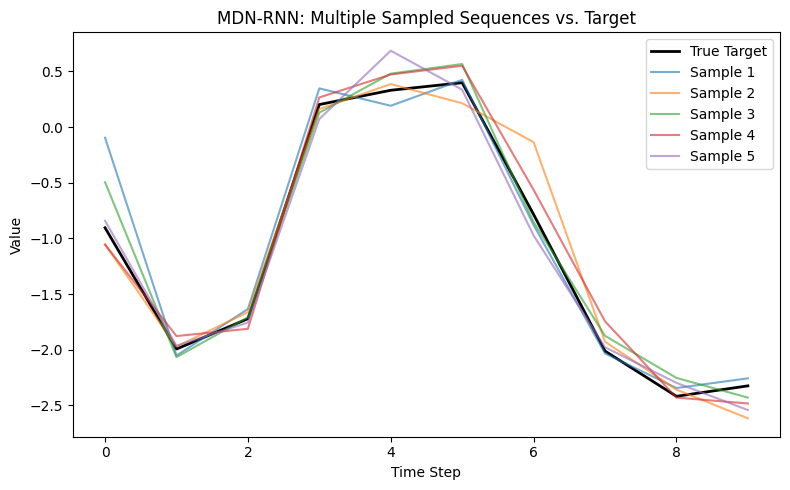

In [65]:
n_samples = 5  # number of sample rollouts
with torch.no_grad():
    pi, mu, sigma, _ = model(x)

    all_samples = []
    for _ in range(n_samples):
        sample = sample_from_mdn(pi, mu, sigma)  # shape: (batch, seq_len, output_dim)
        all_samples.append(sample)

    # Convert to shape: (n_samples, batch, seq_len, output_dim)
    all_samples = torch.stack(all_samples)

# Let's plot for the first sequence in the batch (index 0)
seq_idx = 0
time = range(seq_len)

plt.figure(figsize=(8, 5))

# Plot true target sequence
plt.plot(time, target[seq_idx,:,0].numpy(), label="True Target", color="black", linewidth=2)

# Plot sampled sequences
for i in range(n_samples):
    plt.plot(time, all_samples[i, seq_idx,:,0].numpy(), label=f"Sample {i+1}", alpha=0.6)

plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("MDN-RNN: Multiple Sampled Sequences vs. Target")
plt.legend()
plt.tight_layout()
plt.show()
